# Segmentation(Deep Lab v3)
Objective:
    
    1. 객체와 배경 나누기
    2. 배경 블러처리
    사진의 주인공을 다른 것과 바꿔라 (semantic segmentation)
        ex) 고양이
    3. 배경사진 바꿔보기

In [1]:
! pip install pixellib
! pip3 install tensorflow==2.6.0
! pip3 install keras==2.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
thinc 8.1.0 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.3.0 which is incompatible.
tensorflow 2.6.0+zzzcolab20220506153740 requires typing-extensions~=3.7.4, but you have typing-extensions 4.3.0 which is incompatible.
spacy 3.4.1 requires typing-extensions<4.2.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.3.0 which is incompatible.
jax 0.3.17 require

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Libraries

import os
import urllib # 웹에서 데이터를 다운로드할 때 사용
import cv2
import numpy as np
import pixellib

from google.colab.patches import cv2_imshow
from pixellib.semantic import semantic_segmentation # 시맨틱 세그멘테이션을 사용하기 위한 라이브러리
from matplotlib import pyplot as plt

(960, 1280, 3)


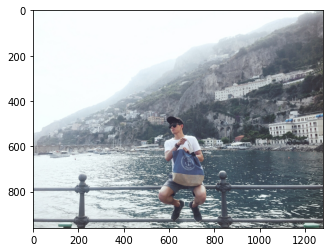

In [4]:
# 사진 1

# cv2로 이미지 불러와서 다시 

img_path = '/content/drive/MyDrive/나폴리.jpg'
img_orig = cv2.imread(img_path) # 파일 경로를 변수에 저장하기
print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)) # BGR2RGB
plt.show()

웹에서 모델 가져오기
_________________


In [5]:
# PixelLib에서 제공해 주는 모델 다운받기

# 저장할 파일명 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드하기
urllib.request.urlretrieve(model_url, model_file)

('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f113eaf3e10>)

In [6]:
# 세그멘테이션모델 생성

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 모델 이미지 입력(Pascolvoc 데이터셋에 pretrained된 모델을 사용)
segvalues, output = model.segmentAsPascalvoc(img_path) 

In [7]:
# PASCAL VOC 데이터셋내 라벨들
# background 제외 20개의 라벨이 존재

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

len(LABEL_NAMES)

21

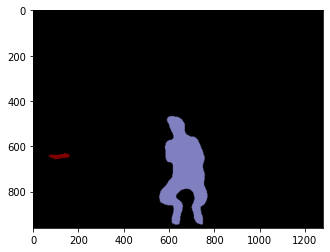

In [8]:
plt.imshow(output) #모델에서 나온 출력값을 살펴보기
plt.show()

In [9]:
# 이미지내 탐지된 class_id들 출력

for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id]) 

background
boat
person


In [10]:
# 물체마다 output에서 어떤 색상이 나타나 있는 지 출력

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [12]:
colormap[15] # (인덱스 15번) 사람을 나타내는 색 알아보기

# 인덱스 번호에 따라 해당 클라스 아이디를 살펴볼 수 있다

# --> 사람 외 다른 물체를 찾고 싶다면 colormap[class_id]
#    예) 고양이는 colormap[8]

# 주의할 점: output은 BGR 순서이다! 하지만 colormap은 RGB순!

# --> 따라서 색상 값의 순서를 바꿔 줄 필요가 있다

array([192, 128, 128])

In [13]:
# 192 와 129의 순서 혹은 위치를 해당 색상 (R or G or B)에 적어주자
seg_color = (128,128,192) 

(960, 1280)


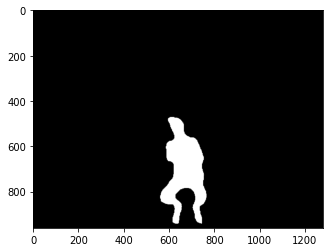

In [14]:
# seg color로 이루어진 마스크 생성
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 된다

seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray') # cmap=gray (grayscale로 변경)
plt.show()

 # image 를 grayscale 로 바꿔주는 이유
 
# (워터쉐드 세그멘테이션 watershed segmentation) grayscale로 변환하면 0~255의 픽셀 값으로 위치의 높고 낮음을 구분하여 경계선을 구분한다.

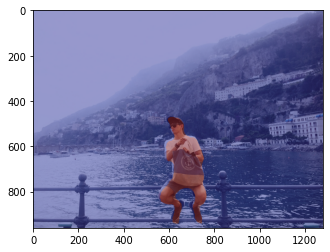

In [15]:
# 기존 이미지와 겹쳐 세그멘테이션 확인
img_show = img_orig.copy() 

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)) # BGR2RGB
plt.show()

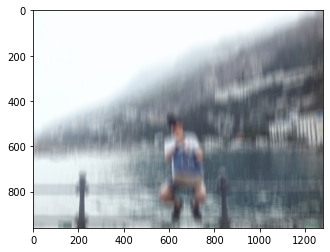

In [16]:
# 배경 흐리게 하기 (shallow focus)

# (13,13)은 blurring kernel size를 뜻합니다

img_orig_blur = cv2.blur(img_orig, (1, 50)) 
# 1, 1이 가장 선명하고 높아질 수록 흐려진다. 
# cv2.blur는 평균 블러링(Average Blurring)

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

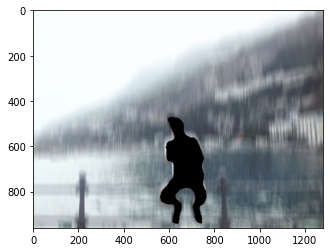

In [17]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하기

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # 채널을 흑백에서 BGR로 변경
img_bg_mask = cv2.bitwise_not(img_mask_color) 
# bitwise_not 함수는 이미지를 반전시켜준다
# 원래 마스크에서는 배경이 0, 사람이 255였고 이를 반대로 바꿔준다

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
# 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 
# !!! 배경만 있는 영상을 얻을 수 있다
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 된다

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

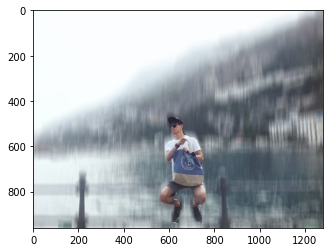

In [18]:
# 배경 영상과 사람 영상을 합친다

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용
# np.where(조건, 참일때, 거짓일때)
# numpy.where - https://numpy.org/doc/stable/reference/generated/numpy.where.html

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

(641, 640, 3)


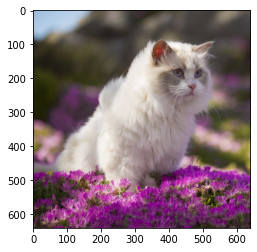

In [19]:
# 고양이 사진

cat_img_path = '/content/drive/MyDrive/pics/cat.jpg'
cat_img_orig = cv2.imread(cat_img_path) 

print(cat_img_orig.shape)
plt.imshow(cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
cat_model = semantic_segmentation()
cat_model.load_pascalvoc_model(model_file)
cat_segvalues, cat_output = model.segmentAsPascalvoc(cat_img_path)

<function matplotlib.pyplot.show(*args, **kw)>

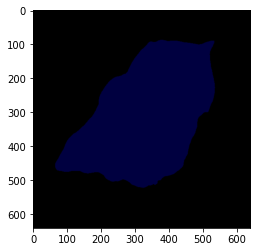

In [21]:
plt.imshow(cat_output)
plt.show

In [22]:
cat_segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [23]:
for class_id in cat_segvalues['class_ids']:
    print(LABEL_NAMES[class_id]) # 세그멘테이션 각 분류의 ID를 출력해주기

background
cat


In [24]:
# 물체마다 output에서 어떤 색상이 나타나 있는지 출력
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [25]:
colormap[8]

array([64,  0,  0])

In [26]:
cat_seg_color = (0, 0, 64)

(641, 640)


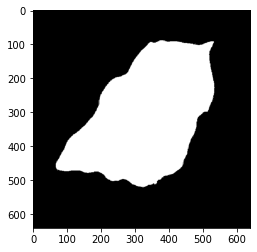

In [27]:
cat_seg_map = np.all(cat_output==cat_seg_color, axis=-1)
print(cat_seg_map.shape)
plt.imshow(cat_seg_map, cmap='gray')
plt.show()

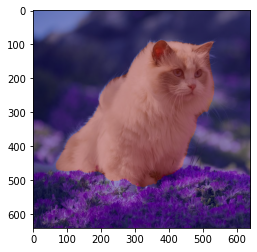

In [28]:
# 원래 이미지와 겹쳐 세그멘테이션을 확인
cat_img_show = cat_img_orig.copy()

# True과 False인 값을 각각 255과 0으로 변경
cat_img_mask = cat_seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변경
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 결합
# 0.6과 0.4는 두 이미지를 섞는 비율
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()

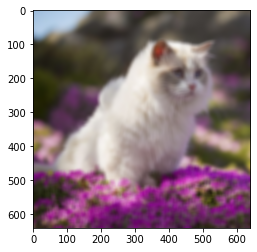

In [29]:
# 배경을 흐리게 변경
cat_img_orig_blur = cv2.blur(cat_img_orig, (13,13))  
plt.imshow(cv2.cvtColor(cat_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

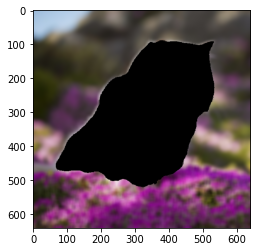

In [30]:
# 흐린 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
cat_img_mask_color = cv2.cvtColor(cat_img_mask, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg_blur = cv2.bitwise_and(cat_img_orig_blur, cat_img_bg_mask)
plt.imshow(cv2.cvtColor(cat_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

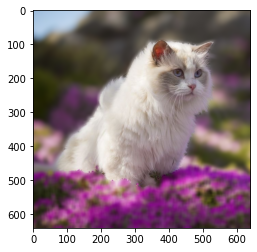

In [31]:
# 처리한 배경과 고양이 합체
cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 다른 배경에 마스크 삽입

(549, 976, 3)


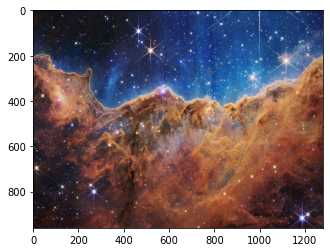

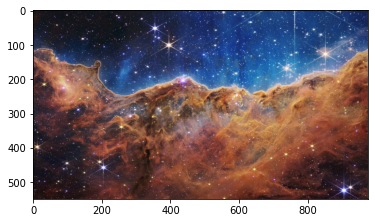

In [32]:
# 배경 사진

bg_img_path = '/content/drive/MyDrive/important files/me/space.png'  
bg_orig = cv2.imread(bg_img_path)
print(bg_orig.shape)

# 사진 resize

resized = cv2.resize(bg_orig, dsize=(1280,960), interpolation=cv2.INTER_AREA)
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.show()

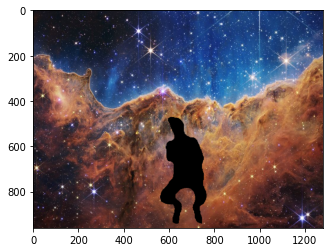

In [34]:
img_mask = seg_map.astype(np.uint8) * 255

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(resized, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB))
plt.show()

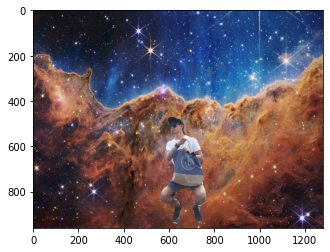

In [36]:
bg_img_concat = np.where(img_mask_color==255, img_orig, resized)
plt.imshow(cv2.cvtColor(bg_img_concat, cv2.COLOR_BGR2RGB))
plt.show()